In [1]:
import json

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots as plots
import tensorflow_docs.modeling

In [2]:
keras.__version__

'2.3.0-tf'

## Reading the Insurance data

In [3]:
data=pd.read_csv('datasets/insurance.csv')
data.sample(10)

,age,sex,bmi,children,smoker,region,charges
440,31,female,32.680,1,no,northwest,4738.26820
637,35,female,38.095,2,no,northeast,24915.04626
949,25,male,29.700,3,yes,southwest,19933.45800
1262,41,female,28.050,1,no,southeast,6770.19250
1159,32,female,41.100,0,no,southwest,3989.84100
691,47,male,36.200,1,no,southwest,8068.18500
1061,57,male,27.940,1,no,southeast,11554.22360
435,60,male,33.110,3,no,southeast,13919.82290
753,58,female,22.770,0,no,southeast,11833.78230
1168,32,male,35.200,2,no,southwest,4670.64000


Characters of an individual along with the insurance charges that they are charged.

In [4]:
data.shape

(1338, 7)

### Checking null values

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Checking numeric values

In [7]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [8]:
data[['age','bmi','charges']].describe()

,age,bmi,charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265
std,14.049960,6.098187,12110.011237
min,18.000000,15.960000,1121.873900
25%,27.000000,26.296250,4740.287150
50%,39.000000,30.400000,9382.033000
75%,51.000000,34.693750,16639.912515
max,64.000000,53.130000,63770.428010


We see that the value of mean and std. are very different for all the numeric variables, hence we need to preprocess the data

### Checking Categorical columns

In [9]:
data['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [10]:
data['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

Data is skewed more towards non-smokers than towards smokers.

In [11]:
data['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

Individuals are equally distributed among various regions.

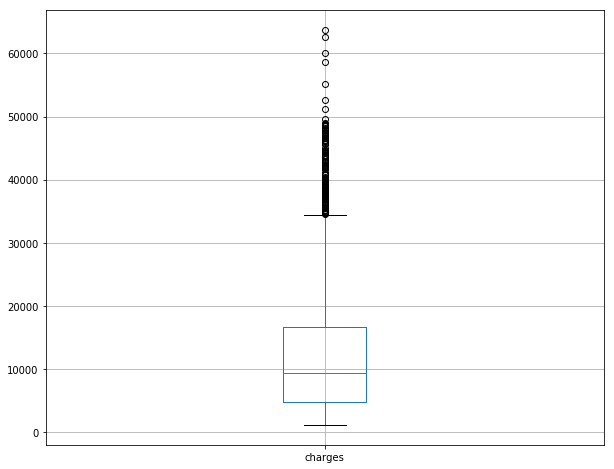

In [12]:
# Let's see how insurance charges are distributed via box plot.
plt.figure(figsize=(10,8))
data.boxplot('charges')
plt.show()

We see that there are many outliers in the data who pay charges in between 35000 to 80000.

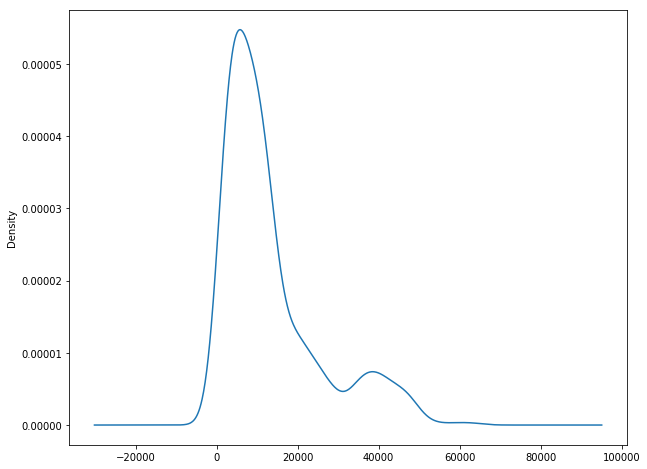

In [13]:
# Visualising the probability distribution of data via KDE.
plt.figure(figsize=(10,8))
data['charges'].plot.kde()
plt.show()

There are 2 pikes in the data one is near 10,000 mark and the other at 40,000 mark.

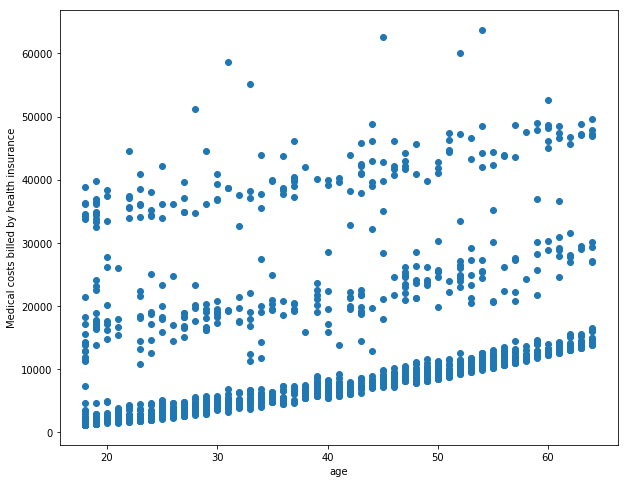

In [14]:
# For bivariate visualisation Scatter plot is the best choice.
plt.figure(figsize=(10,8))
plt.scatter(data['age'],data['charges'])
plt.xlabel('age')
plt.ylabel('Medical costs billed by health insurance')
plt.show()

We can see clearly that there is a linear relation between increase in age and the insurance amount.

### Preparing the data

In [15]:
features=data.drop(['charges'],axis=1)
target=data['charges']

In [16]:
# Extracting the categorical data as preprocessing on categorica
# data is different than in numerical case.
categorical_features=features[['sex','smoker','region']].copy()

categorical_features.head()

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest


In [17]:
numerical_features=features.drop(['sex','smoker','region'],axis=1)

numerical_features.head()

,age,bmi,children
0,19,27.900,0
1,18,33.770,1
2,28,33.000,3
3,33,22.705,0
4,32,28.880,0


### Encoding Catergorical values

In [18]:
# Encoding 'sex'
gend_dict={'male':0,'female':1}
categorical_features['sex'].replace(gend_dict,inplace=True)

categorical_features.head()

# can also use
#categorical_features['sex']=categorical_features['sex'].map(gend_dict)

,sex,smoker,region
0,1,yes,southwest
1,0,no,southeast
2,0,no,southeast
3,0,no,northwest
4,0,no,northwest


In [19]:
# Label encoding to smoker data
smoker_dict={'no':0,'yes':1}
categorical_features['smoker'].replace(smoker_dict,inplace=True)

categorical_features.head()

,sex,smoker,region
0,1,1,southwest
1,0,0,southeast
2,0,0,southeast
3,0,0,northwest
4,0,0,northwest


In [20]:
# using one-hot encoding for region column
categorical_features=pd.get_dummies(categorical_features,columns=['region'])

categorical_features.head()

,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,1,1,0,0,0,1
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


### Preprocessing Numeric data

In [21]:
numerical_features.describe()

,age,bmi,children
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918
std,14.049960,6.098187,1.205493
min,18.000000,15.960000,0.000000
25%,27.000000,26.296250,0.000000
50%,39.000000,30.400000,1.000000
75%,51.000000,34.693750,2.000000
max,64.000000,53.130000,5.000000


In [22]:
# Bringing all the data on the same scale
scaler=StandardScaler()

numerical_features=pd.DataFrame(scaler.fit_transform(numerical_features),
                               columns=numerical_features.columns,
                               index=numerical_features.index)

numerical_features.describe()

,age,bmi,children
count,1.338000e+03,1.338000e+03,1.338000e+03
mean,-1.805565e-16,-2.124194e-16,-5.576008e-17
std,1.000374e+00,1.000374e+00,1.000374e+00
min,-1.509965e+00,-2.412011e+00,-9.086137e-01
25%,-8.691547e-01,-7.164063e-01,-9.086137e-01
50%,-1.474046e-02,-4.320880e-02,-7.876719e-02
75%,8.396738e-01,6.611572e-01,7.510793e-01
max,1.765289e+00,3.685522e+00,3.240619e+00


Hence we have a new data with mean almost 0 and the std dev of nearly 1

In [23]:
# Combining all the preprocessed data
processed_features=pd.concat([numerical_features,categorical_features],axis=1,sort=False)

processed_features.head()

,age,bmi,children,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,1,1,0,0,0,1
1,-1.509965,0.509621,-0.078767,0,0,0,0,1,0
2,-0.797954,0.383307,1.580926,0,0,0,0,1,0
3,-0.441948,-1.305531,-0.908614,0,0,0,1,0,0
4,-0.513149,-0.292556,-0.908614,0,0,0,1,0,0


In [24]:
# Combining target with the processed_features data that'll be used for 
# training
processed_data=pd.concat([processed_features,target],axis=1,sort=False)

processed_data.head()

,age,bmi,children,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest,charges
0,-1.438764,-0.453320,-0.908614,1,1,0,0,0,1,16884.92400
1,-1.509965,0.509621,-0.078767,0,0,0,0,1,0,1725.55230
2,-0.797954,0.383307,1.580926,0,0,0,0,1,0,4449.46200
3,-0.441948,-1.305531,-0.908614,0,0,0,1,0,0,21984.47061
4,-0.513149,-0.292556,-0.908614,0,0,0,1,0,0,3866.85520


In [25]:
# Saving the above file in dataset for further usage
processed_data.to_csv('datasets/insurance_processed.csv',index=False)

## Loading pre-processed data

In [9]:
processed_data=pd.read_csv('datasets/insurance_processed.csv')
processed_data.head()

processed_features=processed_data.drop('charges',axis=1)
target=processed_data['charges']

In [10]:
# Split the data into training and testing
x_train,x_test,y_train,y_test=train_test_split(processed_features,
                                              target,
                                              test_size=0.2,random_state=1)

x_train.shape,x_test.shape

((1070, 9), (268, 9))

## Building a Sequential Model

In [11]:
# Weights of every layer are initialized using Glorot uniform initializer 
# and biases are set to Zero

def build_model():
    model=tf.keras.Sequential([
        layers.Dense(32,activation='relu',input_shape=[len(x_train.keys())]),
        layers.Dense(64,activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    
    # Doesn't train the model but configures the model for training
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae','mse'])
    
    return model

In [12]:
model_relu_64=build_model()

# summary() gives a quick overview of the configuration of NN
model_relu_64.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


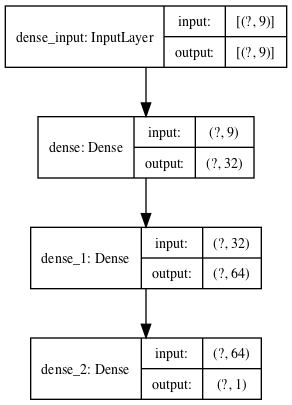

In [13]:
# Visual representation of the model
keras.utils.plot_model(model_relu_64,show_shapes=True)

'?' refers to the batch size of the data that we'll be using.

In [14]:
# Training the model using .fit()
n_epochs=1000

# Input data can be of type numpy array or tf datasets
training_hist=model_relu_64.fit(x_train,
                               y_train,
                               epochs=n_epochs,
                               validation_split=0.2,
                               verbose=True)

Epoch 1/1000
27/27 [==============================] - 0s 9ms/step - loss: 317062336.0000 - mae: 13317.8281 - mse: 317062336.0000 - val_loss: 336112480.0000 - val_mae: 12877.2012 - val_mse: 336112480.0000
Epoch 2/1000
27/27 [==============================] - 0s 2ms/step - loss: 317025408.0000 - mae: 13316.4951 - mse: 317025408.0000 - val_loss: 336065312.0000 - val_mae: 12875.4355 - val_mse: 336065312.0000
Epoch 3/1000
27/27 [==============================] - 0s 3ms/step - loss: 316948704.0000 - mae: 13313.8340 - mse: 316948704.0000 - val_loss: 335961088.0000 - val_mae: 12871.6719 - val_mse: 335961088.0000
Epoch 4/1000
27/27 [==============================] - 0s 3ms/step - loss: 316786208.0000 - mae: 13308.2080 - mse: 316786208.0000 - val_loss: 335746752.0000 - val_mae: 12864.1670 - val_mse: 335746752.0000
Epoch 5/1000
27/27 [==============================] - 0s 4ms/step - loss: 316478048.0000 - mae: 13297.5771 - mse: 316478048.0000 - val_loss: 335356128.0000 - val_mae: 12850.7598 - val_

27/27 [==============================] - 0s 4ms/step - loss: 102152440.0000 - mae: 7106.3428 - mse: 102152440.0000 - val_loss: 117852856.0000 - val_mae: 7291.8608 - val_mse: 117852856.0000
Epoch 42/1000
27/27 [==============================] - 0s 3ms/step - loss: 100415976.0000 - mae: 7167.5591 - mse: 100415976.0000 - val_loss: 115623264.0000 - val_mae: 7343.8867 - val_mse: 115623264.0000
Epoch 43/1000
27/27 [==============================] - 0s 3ms/step - loss: 98789064.0000 - mae: 7203.4546 - mse: 98789064.0000 - val_loss: 113816952.0000 - val_mae: 7385.0898 - val_mse: 113816952.0000
Epoch 44/1000
27/27 [==============================] - 0s 3ms/step - loss: 97420960.0000 - mae: 7236.7920 - mse: 97420960.0000 - val_loss: 112208448.0000 - val_mae: 7421.6973 - val_mse: 112208448.0000
Epoch 45/1000
27/27 [==============================] - 0s 3ms/step - loss: 96220592.0000 - mae: 7269.0845 - mse: 96220592.0000 - val_loss: 110643408.0000 - val_mae: 7454.8662 - val_mse: 110643408.0000
Epoch

27/27 [==============================] - 0s 2ms/step - loss: 66904848.0000 - mae: 6357.1245 - mse: 66904848.0000 - val_loss: 76556280.0000 - val_mae: 6652.1069 - val_mse: 76556280.0000
Epoch 83/1000
27/27 [==============================] - 0s 2ms/step - loss: 66216548.0000 - mae: 6331.7451 - mse: 66216548.0000 - val_loss: 75689832.0000 - val_mae: 6618.9883 - val_mse: 75689832.0000
Epoch 84/1000
27/27 [==============================] - 0s 3ms/step - loss: 65485044.0000 - mae: 6286.8657 - mse: 65485044.0000 - val_loss: 74900664.0000 - val_mae: 6583.2271 - val_mse: 74900664.0000
Epoch 85/1000
27/27 [==============================] - 0s 2ms/step - loss: 64770700.0000 - mae: 6238.5244 - mse: 64770700.0000 - val_loss: 74115328.0000 - val_mae: 6531.6909 - val_mse: 74115328.0000
Epoch 86/1000
27/27 [==============================] - 0s 2ms/step - loss: 64085336.0000 - mae: 6219.1250 - mse: 64085336.0000 - val_loss: 73204120.0000 - val_mae: 6518.5986 - val_mse: 73204120.0000
Epoch 87/1000
27/27

27/27 [==============================] - 0s 2ms/step - loss: 43201604.0000 - mae: 5082.8193 - mse: 43201604.0000 - val_loss: 47126120.0000 - val_mae: 5195.3843 - val_mse: 47126120.0000
Epoch 124/1000
27/27 [==============================] - 0s 2ms/step - loss: 42855760.0000 - mae: 5056.2402 - mse: 42855760.0000 - val_loss: 46638472.0000 - val_mae: 5163.9355 - val_mse: 46638472.0000
Epoch 125/1000
27/27 [==============================] - 0s 2ms/step - loss: 42525532.0000 - mae: 5031.5825 - mse: 42525532.0000 - val_loss: 46122060.0000 - val_mae: 5134.2539 - val_mse: 46122060.0000
Epoch 126/1000
27/27 [==============================] - 0s 2ms/step - loss: 42201580.0000 - mae: 5005.2686 - mse: 42201580.0000 - val_loss: 45676304.0000 - val_mae: 5095.3481 - val_mse: 45676304.0000
Epoch 127/1000
27/27 [==============================] - 0s 2ms/step - loss: 41904364.0000 - mae: 4996.7119 - mse: 41904364.0000 - val_loss: 45199416.0000 - val_mae: 5088.2837 - val_mse: 45199416.0000
Epoch 128/1000


27/27 [==============================] - 0s 2ms/step - loss: 36749404.0000 - mae: 4331.9141 - mse: 36749404.0000 - val_loss: 36168508.0000 - val_mae: 4187.8018 - val_mse: 36168508.0000
Epoch 165/1000
27/27 [==============================] - 0s 2ms/step - loss: 36715660.0000 - mae: 4307.3267 - mse: 36715660.0000 - val_loss: 36077796.0000 - val_mae: 4166.3208 - val_mse: 36077796.0000
Epoch 166/1000
27/27 [==============================] - 0s 2ms/step - loss: 36668096.0000 - mae: 4303.0459 - mse: 36668096.0000 - val_loss: 35953760.0000 - val_mae: 4163.7812 - val_mse: 35953760.0000
Epoch 167/1000
27/27 [==============================] - 0s 2ms/step - loss: 36631572.0000 - mae: 4299.4873 - mse: 36631572.0000 - val_loss: 35842940.0000 - val_mae: 4160.1411 - val_mse: 35842940.0000
Epoch 168/1000
27/27 [==============================] - 0s 2ms/step - loss: 36583832.0000 - mae: 4297.5957 - mse: 36583832.0000 - val_loss: 35786556.0000 - val_mae: 4145.2397 - val_mse: 35786556.0000
Epoch 169/1000


27/27 [==============================] - 0s 3ms/step - loss: 35685576.0000 - mae: 4116.9077 - mse: 35685576.0000 - val_loss: 33728708.0000 - val_mae: 3898.6682 - val_mse: 33728712.0000
Epoch 206/1000
27/27 [==============================] - 0s 3ms/step - loss: 35669656.0000 - mae: 4117.1724 - mse: 35669656.0000 - val_loss: 33657540.0000 - val_mae: 3898.6943 - val_mse: 33657540.0000
Epoch 207/1000
27/27 [==============================] - 0s 3ms/step - loss: 35674280.0000 - mae: 4110.5806 - mse: 35674280.0000 - val_loss: 33629928.0000 - val_mae: 3880.8418 - val_mse: 33629928.0000
Epoch 208/1000
27/27 [==============================] - 0s 4ms/step - loss: 35634136.0000 - mae: 4109.8135 - mse: 35634136.0000 - val_loss: 33618560.0000 - val_mae: 3892.0688 - val_mse: 33618560.0000
Epoch 209/1000
27/27 [==============================] - 0s 3ms/step - loss: 35629808.0000 - mae: 4109.2539 - mse: 35629808.0000 - val_loss: 33586256.0000 - val_mae: 3888.1096 - val_mse: 33586260.0000
Epoch 210/1000


27/27 [==============================] - 0s 2ms/step - loss: 34942384.0000 - mae: 4037.0823 - mse: 34942384.0000 - val_loss: 32533736.0000 - val_mae: 3811.3989 - val_mse: 32533736.0000
Epoch 247/1000
27/27 [==============================] - 0s 2ms/step - loss: 34922652.0000 - mae: 4039.8958 - mse: 34922652.0000 - val_loss: 32524678.0000 - val_mae: 3815.7986 - val_mse: 32524678.0000
Epoch 248/1000
27/27 [==============================] - 0s 2ms/step - loss: 34897844.0000 - mae: 4043.1545 - mse: 34897844.0000 - val_loss: 32471084.0000 - val_mae: 3818.9817 - val_mse: 32471084.0000
Epoch 249/1000
27/27 [==============================] - 0s 2ms/step - loss: 34884556.0000 - mae: 4038.0447 - mse: 34884556.0000 - val_loss: 32462986.0000 - val_mae: 3813.6028 - val_mse: 32462986.0000
Epoch 250/1000
27/27 [==============================] - 0s 2ms/step - loss: 34862644.0000 - mae: 4043.3069 - mse: 34862644.0000 - val_loss: 32431942.0000 - val_mae: 3816.1716 - val_mse: 32431942.0000
Epoch 251/1000


Epoch 287/1000
27/27 [==============================] - 0s 2ms/step - loss: 33735252.0000 - mae: 3930.6814 - mse: 33735252.0000 - val_loss: 31440758.0000 - val_mae: 3721.4087 - val_mse: 31440758.0000
Epoch 288/1000
27/27 [==============================] - 0s 2ms/step - loss: 33766416.0000 - mae: 3949.0850 - mse: 33766416.0000 - val_loss: 31390852.0000 - val_mae: 3733.8079 - val_mse: 31390852.0000
Epoch 289/1000
27/27 [==============================] - 0s 2ms/step - loss: 33693188.0000 - mae: 3926.1440 - mse: 33693188.0000 - val_loss: 31374314.0000 - val_mae: 3706.5088 - val_mse: 31374314.0000
Epoch 290/1000
27/27 [==============================] - 0s 2ms/step - loss: 33634320.0000 - mae: 3922.8750 - mse: 33634320.0000 - val_loss: 31339638.0000 - val_mae: 3722.1917 - val_mse: 31339638.0000
Epoch 291/1000
27/27 [==============================] - 0s 2ms/step - loss: 33596688.0000 - mae: 3926.0674 - mse: 33596688.0000 - val_loss: 31325026.0000 - val_mae: 3717.0881 - val_mse: 31325026.0000


Epoch 328/1000
27/27 [==============================] - 0s 3ms/step - loss: 32254996.0000 - mae: 3786.9893 - mse: 32254996.0000 - val_loss: 30249936.0000 - val_mae: 3580.3418 - val_mse: 30249936.0000
Epoch 329/1000
27/27 [==============================] - 0s 3ms/step - loss: 32202444.0000 - mae: 3786.9817 - mse: 32202444.0000 - val_loss: 30219410.0000 - val_mae: 3586.7957 - val_mse: 30219410.0000
Epoch 330/1000
27/27 [==============================] - 0s 3ms/step - loss: 32160406.0000 - mae: 3780.8369 - mse: 32160406.0000 - val_loss: 30206614.0000 - val_mae: 3579.6194 - val_mse: 30206612.0000
Epoch 331/1000
27/27 [==============================] - 0s 4ms/step - loss: 32120870.0000 - mae: 3773.3257 - mse: 32120870.0000 - val_loss: 30176186.0000 - val_mae: 3573.5520 - val_mse: 30176186.0000
Epoch 332/1000
27/27 [==============================] - 0s 3ms/step - loss: 32073858.0000 - mae: 3776.7947 - mse: 32073858.0000 - val_loss: 30146720.0000 - val_mae: 3581.1736 - val_mse: 30146720.0000


Epoch 369/1000
27/27 [==============================] - 0s 4ms/step - loss: 30576788.0000 - mae: 3608.1069 - mse: 30576788.0000 - val_loss: 29118900.0000 - val_mae: 3415.2996 - val_mse: 29118900.0000
Epoch 370/1000
27/27 [==============================] - 0s 3ms/step - loss: 30549996.0000 - mae: 3624.1775 - mse: 30549996.0000 - val_loss: 29109944.0000 - val_mae: 3430.3511 - val_mse: 29109944.0000
Epoch 371/1000
27/27 [==============================] - 0s 3ms/step - loss: 30482598.0000 - mae: 3607.4675 - mse: 30482598.0000 - val_loss: 29068182.0000 - val_mae: 3415.7527 - val_mse: 29068186.0000
Epoch 372/1000
27/27 [==============================] - 0s 3ms/step - loss: 30449516.0000 - mae: 3615.1575 - mse: 30449516.0000 - val_loss: 29070064.0000 - val_mae: 3423.3115 - val_mse: 29070064.0000
Epoch 373/1000
27/27 [==============================] - 0s 3ms/step - loss: 30403182.0000 - mae: 3602.4929 - mse: 30403182.0000 - val_loss: 29013444.0000 - val_mae: 3413.6509 - val_mse: 29013444.0000


Epoch 410/1000
27/27 [==============================] - 0s 2ms/step - loss: 28904434.0000 - mae: 3463.8201 - mse: 28904434.0000 - val_loss: 28033096.0000 - val_mae: 3279.6631 - val_mse: 28033096.0000
Epoch 411/1000
27/27 [==============================] - 0s 2ms/step - loss: 28859278.0000 - mae: 3458.9158 - mse: 28859278.0000 - val_loss: 28008496.0000 - val_mae: 3279.5459 - val_mse: 28008496.0000
Epoch 412/1000
27/27 [==============================] - 0s 2ms/step - loss: 28819022.0000 - mae: 3440.1978 - mse: 28819022.0000 - val_loss: 27969608.0000 - val_mae: 3260.6233 - val_mse: 27969608.0000
Epoch 413/1000
27/27 [==============================] - 0s 2ms/step - loss: 28772740.0000 - mae: 3438.2278 - mse: 28772740.0000 - val_loss: 27955850.0000 - val_mae: 3266.3218 - val_mse: 27955850.0000
Epoch 414/1000
27/27 [==============================] - 0s 2ms/step - loss: 28732526.0000 - mae: 3436.5356 - mse: 28732526.0000 - val_loss: 27939680.0000 - val_mae: 3261.7546 - val_mse: 27939680.0000


Epoch 451/1000
27/27 [==============================] - 0s 2ms/step - loss: 27307864.0000 - mae: 3295.6797 - mse: 27307864.0000 - val_loss: 26967784.0000 - val_mae: 3117.3481 - val_mse: 26967784.0000
Epoch 452/1000
27/27 [==============================] - 0s 2ms/step - loss: 27270426.0000 - mae: 3295.3484 - mse: 27270426.0000 - val_loss: 26946466.0000 - val_mae: 3112.0322 - val_mse: 26946470.0000
Epoch 453/1000
27/27 [==============================] - 0s 2ms/step - loss: 27230692.0000 - mae: 3294.6394 - mse: 27230692.0000 - val_loss: 26959888.0000 - val_mae: 3115.5686 - val_mse: 26959888.0000
Epoch 454/1000
27/27 [==============================] - 0s 3ms/step - loss: 27204094.0000 - mae: 3282.8755 - mse: 27204094.0000 - val_loss: 26890942.0000 - val_mae: 3107.6409 - val_mse: 26890942.0000
Epoch 455/1000
27/27 [==============================] - 0s 2ms/step - loss: 27162304.0000 - mae: 3298.1414 - mse: 27162304.0000 - val_loss: 26878760.0000 - val_mae: 3118.6160 - val_mse: 26878760.0000


Epoch 492/1000
27/27 [==============================] - 0s 2ms/step - loss: 25726740.0000 - mae: 3184.7349 - mse: 25726740.0000 - val_loss: 25848722.0000 - val_mae: 2993.2788 - val_mse: 25848722.0000
Epoch 493/1000
27/27 [==============================] - 0s 2ms/step - loss: 25699666.0000 - mae: 3159.2971 - mse: 25699666.0000 - val_loss: 25732302.0000 - val_mae: 2960.5867 - val_mse: 25732302.0000
Epoch 494/1000
27/27 [==============================] - 0s 2ms/step - loss: 25641096.0000 - mae: 3167.3953 - mse: 25641096.0000 - val_loss: 25749878.0000 - val_mae: 2977.4290 - val_mse: 25749878.0000
Epoch 495/1000
27/27 [==============================] - 0s 2ms/step - loss: 25599992.0000 - mae: 3171.2891 - mse: 25599992.0000 - val_loss: 25695440.0000 - val_mae: 2973.4141 - val_mse: 25695440.0000
Epoch 496/1000
27/27 [==============================] - 0s 2ms/step - loss: 25558366.0000 - mae: 3161.9626 - mse: 25558366.0000 - val_loss: 25663346.0000 - val_mae: 2963.9326 - val_mse: 25663346.0000


Epoch 533/1000
27/27 [==============================] - 0s 2ms/step - loss: 24385036.0000 - mae: 3047.9521 - mse: 24385036.0000 - val_loss: 24648538.0000 - val_mae: 2845.4043 - val_mse: 24648538.0000
Epoch 534/1000
27/27 [==============================] - 0s 2ms/step - loss: 24379138.0000 - mae: 3064.4312 - mse: 24379138.0000 - val_loss: 24658676.0000 - val_mae: 2866.6880 - val_mse: 24658674.0000
Epoch 535/1000
27/27 [==============================] - 0s 2ms/step - loss: 24340070.0000 - mae: 3042.7019 - mse: 24340070.0000 - val_loss: 24583070.0000 - val_mae: 2840.1226 - val_mse: 24583070.0000
Epoch 536/1000
27/27 [==============================] - 0s 2ms/step - loss: 24306264.0000 - mae: 3042.8499 - mse: 24306264.0000 - val_loss: 24572466.0000 - val_mae: 2846.8367 - val_mse: 24572466.0000
Epoch 537/1000
27/27 [==============================] - 0s 2ms/step - loss: 24273310.0000 - mae: 3032.5195 - mse: 24273310.0000 - val_loss: 24547978.0000 - val_mae: 2837.9612 - val_mse: 24547978.0000


Epoch 574/1000
27/27 [==============================] - 0s 2ms/step - loss: 23380178.0000 - mae: 2957.5674 - mse: 23380178.0000 - val_loss: 23755938.0000 - val_mae: 2771.8896 - val_mse: 23755938.0000
Epoch 575/1000
27/27 [==============================] - 0s 2ms/step - loss: 23361976.0000 - mae: 2960.6121 - mse: 23361976.0000 - val_loss: 23758496.0000 - val_mae: 2777.7944 - val_mse: 23758496.0000
Epoch 576/1000
27/27 [==============================] - 0s 2ms/step - loss: 23337046.0000 - mae: 2950.1624 - mse: 23337046.0000 - val_loss: 23707394.0000 - val_mae: 2763.2993 - val_mse: 23707394.0000
Epoch 577/1000
27/27 [==============================] - 0s 2ms/step - loss: 23329806.0000 - mae: 2939.6028 - mse: 23329806.0000 - val_loss: 23657436.0000 - val_mae: 2754.1396 - val_mse: 23657436.0000
Epoch 578/1000
27/27 [==============================] - 0s 2ms/step - loss: 23321528.0000 - mae: 2930.9253 - mse: 23321526.0000 - val_loss: 23629884.0000 - val_mae: 2742.3884 - val_mse: 23629884.0000


Epoch 615/1000
27/27 [==============================] - 0s 2ms/step - loss: 22664780.0000 - mae: 2881.9004 - mse: 22664780.0000 - val_loss: 23022734.0000 - val_mae: 2702.4321 - val_mse: 23022734.0000
Epoch 616/1000
27/27 [==============================] - 0s 2ms/step - loss: 22645482.0000 - mae: 2900.1648 - mse: 22645482.0000 - val_loss: 23051320.0000 - val_mae: 2720.1165 - val_mse: 23051320.0000
Epoch 617/1000
27/27 [==============================] - 0s 2ms/step - loss: 22632448.0000 - mae: 2885.0879 - mse: 22632448.0000 - val_loss: 22963788.0000 - val_mae: 2690.0688 - val_mse: 22963788.0000
Epoch 618/1000
27/27 [==============================] - 0s 2ms/step - loss: 22625924.0000 - mae: 2881.3081 - mse: 22625924.0000 - val_loss: 22974866.0000 - val_mae: 2699.5801 - val_mse: 22974866.0000
Epoch 619/1000
27/27 [==============================] - 0s 2ms/step - loss: 22608582.0000 - mae: 2875.0110 - mse: 22608582.0000 - val_loss: 22950554.0000 - val_mae: 2689.9475 - val_mse: 22950554.0000


Epoch 656/1000
27/27 [==============================] - 0s 2ms/step - loss: 22196550.0000 - mae: 2860.9878 - mse: 22196550.0000 - val_loss: 22541846.0000 - val_mae: 2695.2185 - val_mse: 22541846.0000
Epoch 657/1000
27/27 [==============================] - 0s 2ms/step - loss: 22148814.0000 - mae: 2834.9773 - mse: 22148814.0000 - val_loss: 22448192.0000 - val_mae: 2667.2771 - val_mse: 22448192.0000
Epoch 658/1000
27/27 [==============================] - 0s 2ms/step - loss: 22156326.0000 - mae: 2808.5845 - mse: 22156326.0000 - val_loss: 22444722.0000 - val_mae: 2667.4253 - val_mse: 22444722.0000
Epoch 659/1000
27/27 [==============================] - 0s 2ms/step - loss: 22123944.0000 - mae: 2837.9377 - mse: 22123944.0000 - val_loss: 22459902.0000 - val_mae: 2677.2249 - val_mse: 22459902.0000
Epoch 660/1000
27/27 [==============================] - 0s 2ms/step - loss: 22120606.0000 - mae: 2810.4958 - mse: 22120606.0000 - val_loss: 22417588.0000 - val_mae: 2660.3931 - val_mse: 22417588.0000


Epoch 697/1000
27/27 [==============================] - 0s 2ms/step - loss: 21767374.0000 - mae: 2804.9319 - mse: 21767374.0000 - val_loss: 22117500.0000 - val_mae: 2669.7014 - val_mse: 22117500.0000
Epoch 698/1000
27/27 [==============================] - 0s 2ms/step - loss: 21770958.0000 - mae: 2779.4287 - mse: 21770958.0000 - val_loss: 22031970.0000 - val_mae: 2633.2620 - val_mse: 22031970.0000
Epoch 699/1000
27/27 [==============================] - 0s 2ms/step - loss: 21770098.0000 - mae: 2811.0640 - mse: 21770098.0000 - val_loss: 22133496.0000 - val_mae: 2676.8484 - val_mse: 22133496.0000
Epoch 700/1000
27/27 [==============================] - 0s 2ms/step - loss: 21767184.0000 - mae: 2827.9346 - mse: 21767184.0000 - val_loss: 22135006.0000 - val_mae: 2689.1267 - val_mse: 22135006.0000
Epoch 701/1000
27/27 [==============================] - 0s 2ms/step - loss: 21736558.0000 - mae: 2783.8767 - mse: 21736558.0000 - val_loss: 22031672.0000 - val_mae: 2642.2600 - val_mse: 22031672.0000


Epoch 738/1000
27/27 [==============================] - 0s 2ms/step - loss: 21489184.0000 - mae: 2745.0693 - mse: 21489184.0000 - val_loss: 21787408.0000 - val_mae: 2627.7429 - val_mse: 21787408.0000
Epoch 739/1000
27/27 [==============================] - 0s 2ms/step - loss: 21451740.0000 - mae: 2768.8613 - mse: 21451740.0000 - val_loss: 21856890.0000 - val_mae: 2661.2083 - val_mse: 21856890.0000
Epoch 740/1000
27/27 [==============================] - 0s 2ms/step - loss: 21452832.0000 - mae: 2760.8811 - mse: 21452832.0000 - val_loss: 21820846.0000 - val_mae: 2645.1218 - val_mse: 21820846.0000
Epoch 741/1000
27/27 [==============================] - 0s 2ms/step - loss: 21449830.0000 - mae: 2786.6804 - mse: 21449830.0000 - val_loss: 21856088.0000 - val_mae: 2668.7012 - val_mse: 21856088.0000
Epoch 742/1000
27/27 [==============================] - 0s 2ms/step - loss: 21446718.0000 - mae: 2773.6133 - mse: 21446718.0000 - val_loss: 21786902.0000 - val_mae: 2637.8916 - val_mse: 21786902.0000


Epoch 779/1000
27/27 [==============================] - 0s 2ms/step - loss: 21250484.0000 - mae: 2778.2510 - mse: 21250484.0000 - val_loss: 21656222.0000 - val_mae: 2646.0889 - val_mse: 21656222.0000
Epoch 780/1000
27/27 [==============================] - 0s 2ms/step - loss: 21227784.0000 - mae: 2766.1797 - mse: 21227784.0000 - val_loss: 21596804.0000 - val_mae: 2627.9878 - val_mse: 21596804.0000
Epoch 781/1000
27/27 [==============================] - 0s 2ms/step - loss: 21221654.0000 - mae: 2727.9585 - mse: 21221654.0000 - val_loss: 21561550.0000 - val_mae: 2615.7307 - val_mse: 21561550.0000
Epoch 782/1000
27/27 [==============================] - 0s 2ms/step - loss: 21215246.0000 - mae: 2740.3643 - mse: 21215246.0000 - val_loss: 21618444.0000 - val_mae: 2641.0403 - val_mse: 21618444.0000
Epoch 783/1000
27/27 [==============================] - 0s 2ms/step - loss: 21213570.0000 - mae: 2749.2292 - mse: 21213570.0000 - val_loss: 21584190.0000 - val_mae: 2626.3821 - val_mse: 21584190.0000


Epoch 820/1000
27/27 [==============================] - 0s 2ms/step - loss: 21051970.0000 - mae: 2720.4045 - mse: 21051970.0000 - val_loss: 21508148.0000 - val_mae: 2652.3760 - val_mse: 21508148.0000
Epoch 821/1000
27/27 [==============================] - 0s 2ms/step - loss: 21044952.0000 - mae: 2747.3650 - mse: 21044952.0000 - val_loss: 21446404.0000 - val_mae: 2622.6516 - val_mse: 21446404.0000
Epoch 822/1000
27/27 [==============================] - 0s 2ms/step - loss: 21056578.0000 - mae: 2707.1372 - mse: 21056578.0000 - val_loss: 21353274.0000 - val_mae: 2588.0940 - val_mse: 21353274.0000
Epoch 823/1000
27/27 [==============================] - 0s 2ms/step - loss: 21041556.0000 - mae: 2704.0435 - mse: 21041556.0000 - val_loss: 21438346.0000 - val_mae: 2624.0601 - val_mse: 21438346.0000
Epoch 824/1000
27/27 [==============================] - 0s 2ms/step - loss: 21035346.0000 - mae: 2724.0532 - mse: 21035346.0000 - val_loss: 21424814.0000 - val_mae: 2626.6726 - val_mse: 21424814.0000


Epoch 861/1000
27/27 [==============================] - 0s 2ms/step - loss: 20897068.0000 - mae: 2704.6494 - mse: 20897068.0000 - val_loss: 21280166.0000 - val_mae: 2602.6145 - val_mse: 21280166.0000
Epoch 862/1000
27/27 [==============================] - 0s 2ms/step - loss: 20907888.0000 - mae: 2676.6638 - mse: 20907888.0000 - val_loss: 21227788.0000 - val_mae: 2580.5381 - val_mse: 21227788.0000
Epoch 863/1000
27/27 [==============================] - 0s 2ms/step - loss: 20940366.0000 - mae: 2754.0774 - mse: 20940366.0000 - val_loss: 21390982.0000 - val_mae: 2649.0386 - val_mse: 21390982.0000
Epoch 864/1000
27/27 [==============================] - 0s 2ms/step - loss: 20893564.0000 - mae: 2710.9075 - mse: 20893564.0000 - val_loss: 21204356.0000 - val_mae: 2564.6545 - val_mse: 21204356.0000
Epoch 865/1000
27/27 [==============================] - 0s 2ms/step - loss: 20898874.0000 - mae: 2684.8186 - mse: 20898874.0000 - val_loss: 21220158.0000 - val_mae: 2582.8198 - val_mse: 21220158.0000


Epoch 902/1000
27/27 [==============================] - 0s 3ms/step - loss: 20787202.0000 - mae: 2666.8953 - mse: 20787202.0000 - val_loss: 21177944.0000 - val_mae: 2594.0195 - val_mse: 21177944.0000
Epoch 903/1000
27/27 [==============================] - 0s 2ms/step - loss: 20781210.0000 - mae: 2703.1970 - mse: 20781210.0000 - val_loss: 21259930.0000 - val_mae: 2630.8025 - val_mse: 21259930.0000
Epoch 904/1000
27/27 [==============================] - 0s 2ms/step - loss: 20778562.0000 - mae: 2708.7346 - mse: 20778562.0000 - val_loss: 21185234.0000 - val_mae: 2593.4058 - val_mse: 21185234.0000
Epoch 905/1000
27/27 [==============================] - 0s 2ms/step - loss: 20785338.0000 - mae: 2668.8665 - mse: 20785338.0000 - val_loss: 21166458.0000 - val_mae: 2590.5801 - val_mse: 21166458.0000
Epoch 906/1000
27/27 [==============================] - 0s 2ms/step - loss: 20769806.0000 - mae: 2675.7207 - mse: 20769806.0000 - val_loss: 21178224.0000 - val_mae: 2594.8557 - val_mse: 21178224.0000


Epoch 943/1000
27/27 [==============================] - 0s 3ms/step - loss: 20671468.0000 - mae: 2672.9597 - mse: 20671468.0000 - val_loss: 21160744.0000 - val_mae: 2613.5857 - val_mse: 21160744.0000
Epoch 944/1000
27/27 [==============================] - 0s 3ms/step - loss: 20661846.0000 - mae: 2692.4524 - mse: 20661846.0000 - val_loss: 21088710.0000 - val_mae: 2587.1411 - val_mse: 21088710.0000
Epoch 945/1000
27/27 [==============================] - 0s 3ms/step - loss: 20668174.0000 - mae: 2652.1221 - mse: 20668174.0000 - val_loss: 21052250.0000 - val_mae: 2569.6367 - val_mse: 21052250.0000
Epoch 946/1000
27/27 [==============================] - 0s 3ms/step - loss: 20665616.0000 - mae: 2676.3955 - mse: 20665616.0000 - val_loss: 21112454.0000 - val_mae: 2600.1091 - val_mse: 21112454.0000
Epoch 947/1000
27/27 [==============================] - 0s 3ms/step - loss: 20658752.0000 - mae: 2699.4080 - mse: 20658752.0000 - val_loss: 21149046.0000 - val_mae: 2613.3152 - val_mse: 21149046.0000


Epoch 984/1000
27/27 [==============================] - 0s 2ms/step - loss: 20582200.0000 - mae: 2663.2346 - mse: 20582200.0000 - val_loss: 20990792.0000 - val_mae: 2577.8696 - val_mse: 20990792.0000
Epoch 985/1000
27/27 [==============================] - 0s 3ms/step - loss: 20577190.0000 - mae: 2679.6711 - mse: 20577190.0000 - val_loss: 21040884.0000 - val_mae: 2599.2190 - val_mse: 21040884.0000
Epoch 986/1000
27/27 [==============================] - 0s 2ms/step - loss: 20575964.0000 - mae: 2689.4941 - mse: 20575964.0000 - val_loss: 21015524.0000 - val_mae: 2582.4221 - val_mse: 21015524.0000
Epoch 987/1000
27/27 [==============================] - 0s 2ms/step - loss: 20566468.0000 - mae: 2666.3596 - mse: 20566468.0000 - val_loss: 20969566.0000 - val_mae: 2561.6121 - val_mse: 20969566.0000
Epoch 988/1000
27/27 [==============================] - 0s 2ms/step - loss: 20655748.0000 - mae: 2588.9399 - mse: 20655748.0000 - val_loss: 20837298.0000 - val_mae: 2508.4521 - val_mse: 20837298.0000


In [15]:
# Since the values are all stored in training_hist and can be used to
# generate a df for visualisation purpose
training_hist_df=pd.DataFrame(training_hist.history)
training_hist_df['epoch']=training_hist.epoch

training_hist_df.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,317062336.0,13317.828125,317062336.0,336112480.0,12877.201172,336112480.0,0
1,317025408.0,13316.495117,317025408.0,336065312.0,12875.435547,336065312.0,1
2,316948704.0,13313.833984,316948704.0,335961088.0,12871.671875,335961088.0,2
3,316786208.0,13308.208008,316786208.0,335746752.0,12864.166992,335746752.0,3
4,316478048.0,13297.577148,316478048.0,335356128.0,12850.759766,335356128.0,4


## Visualising the metrices

In [16]:
plotter=tfdocs.plots.HistoryPlotter(smoothing_std=2)

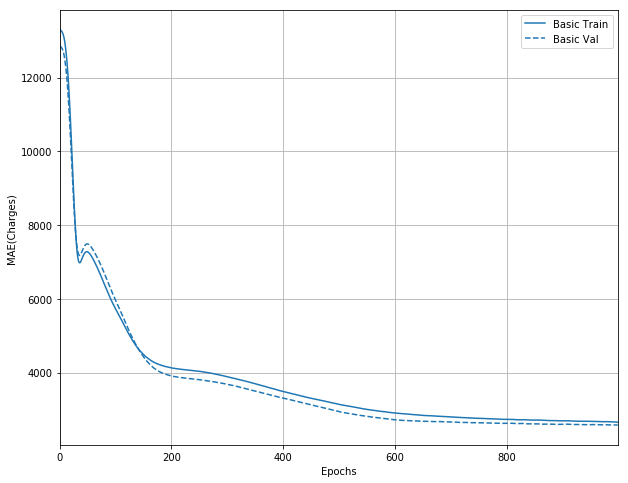

In [17]:
plt.figure(figsize=(10,8))
plotter.plot({'Basic':training_hist},metric='mae')
plt.ylabel('MAE(Charges)')
plt.show()

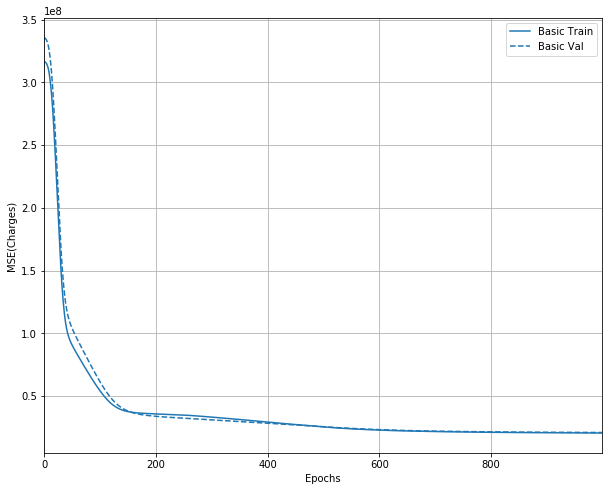

In [18]:
plt.figure(figsize=(10,8))
plotter.plot({'Basic':training_hist},metric='mse')
plt.ylabel('MSE(Charges)')
plt.show()

Hence, we can see that the model MSE value doesn't really change after 400 Epochs and remains the same.

## Predictions

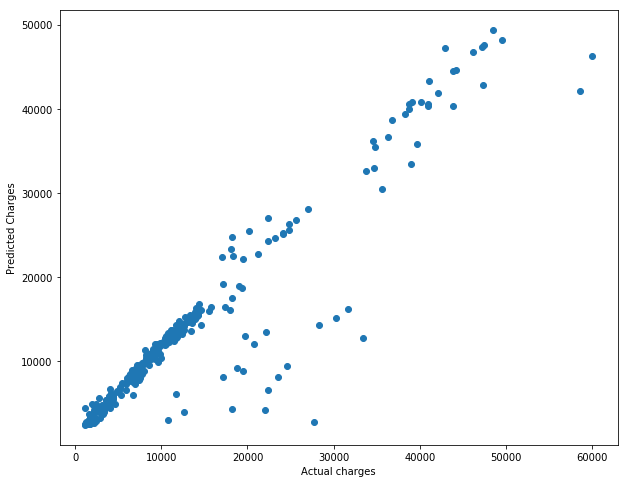

In [19]:
y_pred=model_relu_64.predict(x_test).flatten()

# plotting the predictions against actual values
plt.figure(figsize=(10,8))
plt.scatter(y_test,y_pred)
plt.xlabel('Actual charges')
plt.ylabel('Predicted Charges')
plt.show()

In [20]:
# r2 value
r2_score(y_test,y_pred)

0.8762268238955895

## Building Model 2
('elu' activation function and dropout regularisation)<br>
Exponential Linear Unit or its widely known name ELU is a function that tend to converge cost to zero faster and produce more accurate results. Different to other activation functions, ELU has a extra alpha constant which should be positive number.[elu info](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#elu)

In [21]:
def build_model_2():
    model=tf.keras.Sequential([
        layers.Dense(32,activation='elu',input_shape=[len(x_train.keys())]),
        layers.Dropout(0.2),  # Turns off 20% of neurons
        layers.Dense(64,activation='elu'),
        layers.Dense(1)
    ])
    
    optimizer=tf.keras.optimizers.Adam(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae','mse'])
    
    return model

In [22]:
model_elu_64=build_model_2()

model_elu_64.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                320       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,497
Trainable params: 2,497
Non-trainable params: 0
_________________________________________________________________


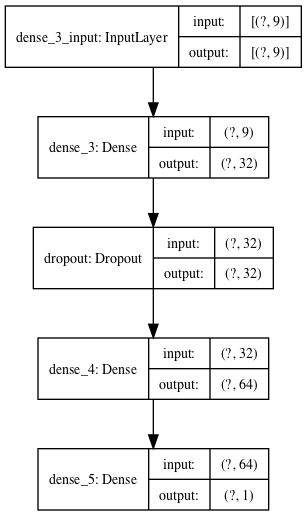

In [23]:
# Visualising the configuration of model
keras.utils.plot_model(model_elu_64,show_shapes=True)

**Callbacks** :
An object passed to a model to extend its behaviour during training, can use custom callbacks or built-in callbacks in Keras. e.g. EpochDots() makes a pretty display of training result.

In [24]:
# training the model again
training_hist=model_elu_64.fit(x_train,
                              y_train,
                              epochs=n_epochs,
                              validation_split=0.2,
                              verbose=False,
                              callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:317048800.0000,  mae:13317.2754,  mse:317048800.0000,  val_loss:336091008.0000,  val_mae:12876.4600,  val_mse:336091008.0000,  
....................................................................................................
Epoch: 100, loss:43885540.0000,  mae:4790.1675,  mse:43885540.0000,  val_loss:44576236.0000,  val_mae:4634.9766,  val_mse:44576236.0000,  
....................................................................................................
Epoch: 200, loss:33092384.0000,  mae:3897.2407,  mse:33092384.0000,  val_loss:24276190.0000,  val_mae:3078.2102,  val_mse:24276190.0000,  
....................................................................................................
Epoch: 300, loss:33018896.0000,  mae:3908.4341,  mse:33018896.0000,  val_loss:23653936.0000,  val_mae:2965.6667,  val_mse:23653936.0000,  
....................................................................................................
Epoch: 400, loss:30081308.0000,  ma

In [25]:
# Creating a dataframe for Visualisation purpose
training_hist_df=pd.DataFrame(training_hist.history)
training_hist_df['epoch']=training_hist.epoch

training_hist_df.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,317048800.0,13317.275391,317048800.0,336091008.0,12876.459961,336091008.0,0
1,316986144.0,13315.208008,316986144.0,336008800.0,12873.661133,336008800.0,1
2,316864160.0,13311.025391,316864160.0,335841824.0,12868.051758,335841824.0,2
3,316628736.0,13303.329102,316628736.0,335568448.0,12858.742188,335568448.0,3
4,316273984.0,13291.048828,316273984.0,335138176.0,12844.226562,335138176.0,4


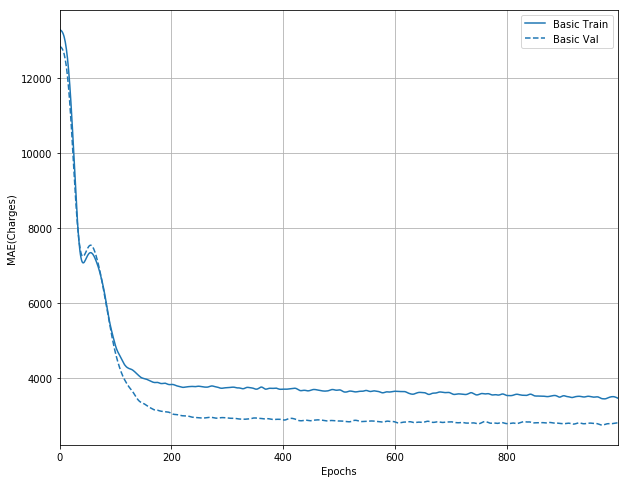

In [26]:
plt.figure(figsize=(10,8))
plotter.plot({'Basic':training_hist},metric='mae')
plt.ylabel('MAE(Charges)')
plt.show()

We can see that the Validation Error is better than the training error and can say safely that the addition of 'DropOut' layer has helped in solving the issue of overfitting.

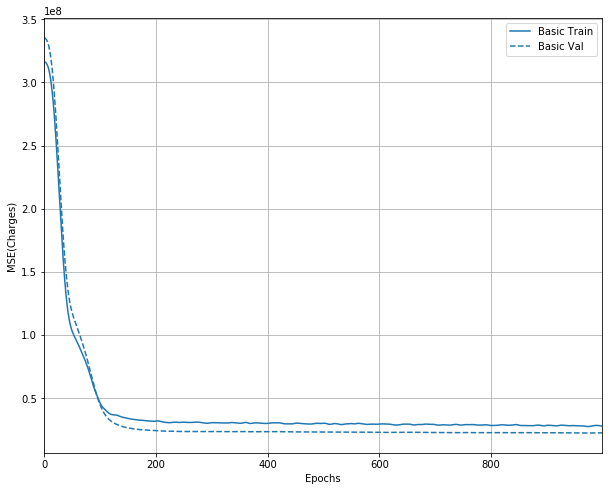

In [27]:
plt.figure(figsize=(10,8))
plotter.plot({'Basic':training_hist},metric='mse')
plt.ylabel('MSE(Charges)')
plt.show()

## Evaluating model on the test data

In [28]:
model_elu_64.evaluate(x_test,y_test)

9/9 [==============================] - 0s 1ms/step - loss: 21974526.0000 - mae: 2854.1543 - mse: 21974526.0000


[21974526.0, 2854.154296875, 21974526.0]

### Plot btw Actual vs Predicted values

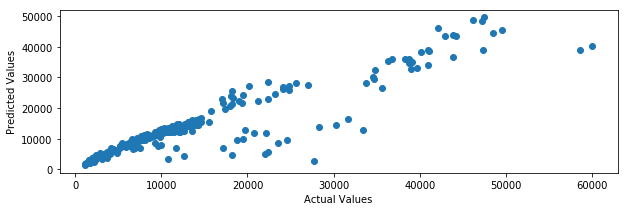

In [30]:
y_pred=model_elu_64.predict(x_test).flatten()

plt.figure(figsize=(10,3))
plt.scatter(y_test,y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [31]:
r2_score(y_test,y_pred)

0.8527972310382715

**Conclusion :**
<br>Though the overall r2_score is less for this model as compared to the above model, but this model tends to be more robust as compared to the above model.

*Note :*<br>
We observed in both the cases that after a particular epoch the values of the losses doesn't really change much hence it's not much useful to train the model after that. This can be acheived by stopping the training at such points and can be done via `early Stopping`

## Relu model with Early Stopping

In [32]:
model_relu_ES=build_model()

# Patience = 5  waits for 5 Epochs to see the change in value 
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

training_hist=model_relu_ES.fit(x_train,
                               y_train,
                               epochs=n_epochs,
                               validation_split=0.2,
                               verbose=False,
                               callbacks=[early_stop,tfdocs.modeling.EpochDots()])


Epoch: 0, loss:317061344.0000,  mae:13317.6904,  mse:317061344.0000,  val_loss:336109504.0000,  val_mae:12876.9023,  val_mse:336109504.0000,  
....................................................................................................
Epoch: 100, loss:46776780.0000,  mae:5376.3770,  mse:46776780.0000,  val_loss:51937288.0000,  val_mae:5534.6519,  val_mse:51937288.0000,  
....................................................................................................
Epoch: 200, loss:35576768.0000,  mae:4110.9775,  mse:35576768.0000,  val_loss:33314612.0000,  val_mae:3869.8933,  val_mse:33314612.0000,  
....................................................................................................
Epoch: 300, loss:32658490.0000,  mae:3833.7751,  mse:32658490.0000,  val_loss:30808846.0000,  val_mae:3640.3857,  val_mse:30808846.0000,  
....................................................................................................
Epoch: 400, loss:28463022.0000,  ma

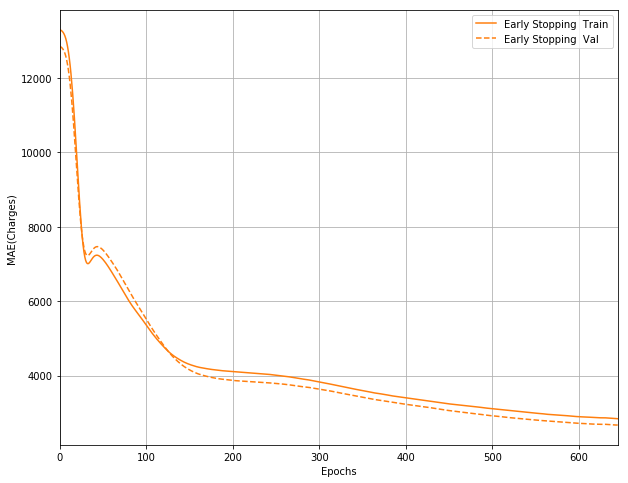

In [33]:
# Visualising the loss
plt.figure(figsize=(10,8))
plotter.plot({'Early Stopping ':training_hist},metric='mae')
plt.ylabel('MAE(Charges)')
plt.show()

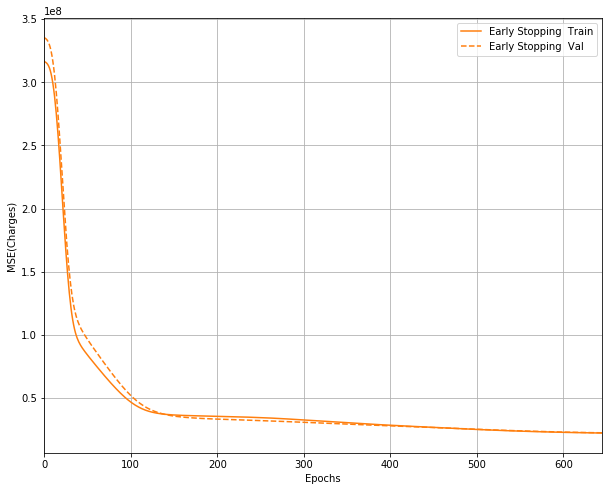

In [34]:
plt.figure(figsize=(10,8))
plotter.plot({'Early Stopping ':training_hist},metric='mse')
plt.ylabel('MSE(Charges)')
plt.show()

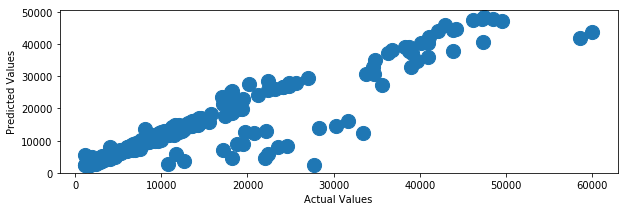

In [35]:
# Using this model for predictions 
y_pred=model_relu_ES.predict(x_test).flatten()

plt.figure(figsize=(10,3))
plt.scatter(y_test,y_pred,s=200)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [36]:
r2_score(y_test,y_pred)

0.8624698711380419

Hence, just for 700 epochs we are getting the same r2 value as for the 1000 epochs

## ELU with Early Stopping

In [37]:
model_elu_ES=build_model_2()

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

training_hist=model_elu_ES.fit(x_train,
                              y_train,
                              epochs=n_epochs,
                              validation_split=0.2,
                              verbose=False,
                              callbacks=[early_stop,tfdocs.modeling.EpochDots()])


Epoch: 0, loss:317052864.0000,  mae:13317.5869,  mse:317052864.0000,  val_loss:336094112.0000,  val_mae:12876.8584,  val_mse:336094112.0000,  
....................................................................................................
Epoch: 100, loss:41389536.0000,  mae:4668.8311,  mse:41389536.0000,  val_loss:38826384.0000,  val_mae:4463.4580,  val_mse:38826384.0000,  
....................................................................................................
Epoch: 200, loss:30955220.0000,  mae:3759.9331,  mse:30955220.0000,  val_loss:24206836.0000,  val_mae:3032.9460,  val_mse:24206836.0000,  
...............................

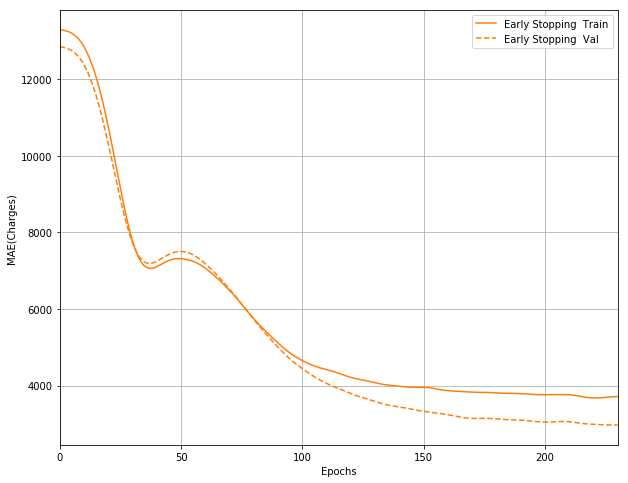

In [38]:
plt.figure(figsize=(10,8))

plotter.plot({'Early Stopping ':training_hist},metric='mae')
plt.ylabel('MAE(Charges)')
plt.show()

Hence, we see that the model stops training after 200 epochs and saves lot of time from training 1000 epochs.

In [40]:
# Checking the r2_score
y_pred=model_elu_ES.predict(x_test).flatten()

r2_score(y_test,y_pred)

0.8414689147752017

## Saving the model

### 1. Saving weights
(Save the model parameters to files using the tf checkpoint format)

In [41]:
model_relu_ES.save_weights('my_models/relu_64_weights')

In [42]:
! ls my_models/

checkpoint                          relu_64_weights.index
relu_64_weights.data-00000-of-00001


In [43]:
# Model weights can also be stored in the Hierarchical Data Format(HDF)
# which is designed to store and organize large amounts of data
model_relu_ES.save_weights('my_models/relu_64_weights.h5',save_format='h5')

In [44]:
! ls my_models/

checkpoint                          relu_64_weights.h5
relu_64_weights.data-00000-of-00001 relu_64_weights.index


It is preferred to use checkpoint format saving of model rather than h5 as it might not work with custom format in TF. It is preferred when a user is implementing multi-backend implementation of keras(different NN frameworks)

### 2. Saving Architecture of the model

In [49]:
import pprint

relu_64_json=model_relu_ES.to_json()

pprint.pprint(json.loads(relu_64_json))

{'backend': 'tensorflow',
 'class_name': 'Sequential',
 'config': {'build_input_shape': [None, 9],
            'layers': [{'class_name': 'Dense',
                        'config': {'activation': 'relu',
                                   'activity_regularizer': None,
                                   'batch_input_shape': [None, 9],
                                   'bias_constraint': None,
                                   'bias_initializer': {'class_name': 'Zeros',
                                                        'config': {}},
                                   'bias_regularizer': None,
                                   'dtype': 'float32',
                                   'kernel_constraint': None,
                                   'kernel_initializer': {'class_name': 'GlorotUniform',
                                                          'config': {'seed': None}},
                                   'kernel_regularizer': None,
                                   'name

In [50]:
with open('my_models/relu_64_config.json','w') as outfile:
    outfile.write(relu_64_json)

In [51]:
! cat my_models/relu_64_config.json

{"class_name": "Sequential", "config": {"name": "sequential_2", "layers": [{"class_name": "Dense", "config": {"name": "dense_6", "trainable": true, "batch_input_shape": [null, 9], "dtype": "float32", "units": 32, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_7", "trainable": true, "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "d

### 3. Saving the entire model

In [52]:
# save() method saves the entire model data along with the configuration and parameters
# The model is saved in directory and the model architecture and the training configuration
# are saved in saved_mode.pb, the weigths of the model are stored in the variable/ directory.

model_relu_ES.save('my_models/relu_ES_config_weights')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_models/relu_ES_config_weights/assets


In [53]:
! ls my_models/relu_ES_config_weights/

assets         saved_model.pb variables
